This work was done as part of a three month project in collaboration with the Ion Technology group at the University of Sussex.

In this file we are going to describe some basic concepts in quantum compilation, showing how to implement compilation of quantum gates using Qiskit modules, and finally produce a simulated quantum circuit that we have compiled into the native gate set of a trapped ion quantum computer.

(I updated the code in 2025 to work on the newer version of Qiskit)

# Classical and quantum compilation

Explaining things in quantum mechanics (or quantum information theory, or quantum computing) is usually made easier by making analogies to the classical case where possible. For that reason, we will begin by understanding classical compilation.

Compilation is the process of taking code written in a high level programming language (e.g. Python, C++, HTML, etc.) and converting it into the machine language that a computer can 'understand'. At its lowest level, machine language are the 'zeros and ones' that we often hear of.

Quantum compilation is similar to classical compilation, in that we take a 'high-level' quantum algorithm (which can be expressed as an arbitrary unitary matrix on  qubits) and decompose it into a set of gates that we can actually perform on a quantum computer.

# Why do we need to compile?

By combining unitaries together using tensory products and sequential multiplication, we can express arbitrary quantum algorithms on $n$ qubits as a single unitary opertor in a $2^{n}$ dimensional Hilbert space. If we can express an arbitrary quantum algorithm as a unitary matrix on $n$ qubits, why can't our quantum computers just implement this gate as it is? The answer is that there is no proposed way to implement gates on anything but one or two qubits. Additionally, quantum computers have very large engineering hurdles to overcome in their current state (only implementing single and two qubit gates), so being able to perform gates on multiple qubits is very unlikely to work.

Quantum computation can be implemented on different engineering platforms, such as trapped ions, photons or superconducting qubits. Each of these has their own pros and cons, such as coherence time, gate fidelity, and measurement fidelity. They also all have their own native gate sets, which are the set of gates that can actually be performed on them.

We can think of the native gate set as the 'machine language' of the quantum computer. So long as the native gate set is a universal set, then we can approximate any unitary, and therefore any quantum algorithm, on this quantum computer. For a native gate set to be universal, we mean that any unitary can be approximated to arbitrary accuracy using chains of gates in the set.

# What are the different steps of decomposition?\n",
Say we have a quantum algorithm on $n$ qubits that we want to perform on a quantum computer. We know that this algorithm can be written as a unitary matrix belonging to the group $U \in SU(2^{n})$. From [1] we know that this unitary can be *exactly* decomposed into a product of so called two-level unitaries. These are unitaries that only act non-trivially on two basis states. We also know that these two level unitaries can in turn be exactly decomposed into products of arbitrary single qubit gates, and a two qubit entangling gate such as the CNOT. Putting these ideas together, we find out that arbitrary quantum algorithms can be exactly decomposed into products of arbitrary single qubit gates, and two qubit entangling gates.

So if the native gate set of our quantum computer has access to these gates, we are able to *exactly* execute *any* quantum algorithm on it. Unfortunely, no quantum computing platforms have this capability. By 'arbitrary single qubit gates', what we mean is a rotation on the Bloch sphere, by *any* angle, along *any* axis. The best that quantum computing platforms are able to do is rotations on the Bloch sphere by any angle, along two fixed, perpedicular, axes. Thankfully, though, combinations of such gates allow us to approximate the arbitrary single qubits we require.

So as long as our quantum computer has access to two single qubit rotations, of arbitray angle, along two perpendicular axes of the Bloch sphere, and also has access to a two qubit entangling gate, then we can approximate any unitary with it (and therefore execute any quantum algorithm). Such a set of gates is referred to as a universal gate set.

# Tradeoffs in compilation
    
We can approximate a unitary that we want to implement by chaining together more and more gates from our native gate set. The more gates we use in our approximation the better it will be. If we want to improve the fidelity of our quantum computer, should we just chain together loads and loads of gates from the native gate set, to approximate the unitaries making up the quantum algorithm as closely as possible? No. That idea ignores the fact that each time we phyiscally implement a gate from the native gate set, there is some error associated with it. For this reason, there will be a trade off in the number of gates we use to approximate the unitary that represents the quantum algorithm we want to implement: more gates means that we get a better approximation, but more gates also means more error is accumulated.

# How does our simulator work?

The main goal of this work is to test the fidelity of decomposition. We cannot perform the random two qubit gates used in our quantum volume calculator on a real quantum computer, but we can approximate them using our native gate set.

In this file, we will run two different quantum circuits using the qiskit library. One will run the random two qubit gates as they are, and the other will decompose them into gates that can actually be performed on a trapped ion quantum computer. We will also add noise to this decomposed circuit, to simulate the errors that qubits in real systems pick up (in the form of decoherence, gate errors, and measurement errors). At the end, we run both circuits (ideal and noisy) and then compare the output states from the two. In this way, we can calculate the fidelity of our decomposed circuit, using the Uhlmann's measure of state fidelity [2].

We can then decide on a reasonable fidelity, say 95%, and define the quantum volume as $nm$, provided that the fidelity is above 95%.

We will see below that there are many trade offs to consider when decomposing circuits. We hope that this file will be interesting for users to play around with, and will also provide a good understanding of quantum gate decomposition. Please see the references at the end of the file for an in depth explanation of the concepts in this file.


# Imports

In [1]:
# import regular python packages
import numpy as np
from numpy.polynomial import Polynomial as P
import random


In [2]:
# visualisation
from qiskit.visualization import plot_histogram
# Import from Qiskit Aer noise module
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error, reset_error, thermal_relaxation_error
# Operators
from qiskit.quantum_info import random_unitary



In [3]:
# import other functions for the compiler
from useful_functions import *
from circuit import *
from qiskit.circuit.library import CXGate, RXXGate


# Define basis gate (two-qubit gate) and Euler basis (to decompose single qubit gates)

In [4]:
# basis_gate = MolmerSorensen(np.pi/4)  # basis gate
basis_gate = RXXGate(np.pi/2)  # basis gate
euler_basis = "XYX"  # Euler basis 


# Choose the number of qubits and circuit depth

In [5]:
number_of_qubits = 2 #choose number of qubits
circuit_depth = 1 #choose depth of circuit

# Add errors to gates creating a NoiseModel

In [6]:
# The data below came from a trapped ion quantum computer, and is used to model the noise in the quantum computer.

#single qubit gate data
x = [0.00000927357382,0.00001260986452,0.00002928106781,0.00003274528310,0.00004924902626,0.00006055222635,0.00011460445423,0.00016071899407,0.00022938562612,0.00027801912678,0.00030185445510,0.00043266624068,0.00044177729723,0.00057279002193,0.00057682838342,0.00070890425941,0.00077947268436,0.00079515532825,0.00080682762917,0.00085089608318,0.00100219273868,0.00104089382283,0.00109095947198,0.00104372058209,0.00116174830392,0.00123813079998,0.00129937860462,0.00128349409828,0.00130493212361,0.00139111136819,0.00145414403424,0.00154043057681,0.00153916316729,0.00176066840966,0.00213276093073,0.00245376808135,0.00265083092714,0.00265166760575,0.00324197197114,0.00326583722022,0.00320380389140,0.00328885321692,0.00348062433166,0.00347240388496,0.00323130829847,0.00344292847993,0.00356279994437,0.00383968605530,0.00396580149891,0.00433704004305,0.00426199843599,0.00398851122681,0.00420891018456,0.00397290379810,0.00430589372375,0.00449442198642,0.00528310345302,0.00592808713104,0.00606595182665,0.00596611750736,0.00626052406424,0.00596401086915,0.00559063279007,0.00570511992288,0.00575084539024,0.00610864910472,0.00612002018331,0.00711666299345,0.00719744952783,0.00676697535723,0.00683955664349,0.00737435778289,0.00770993945309,0.00738052359704,0.00789639090326,0.00879793044710,0.00920989799069,0.00917868385183,0.00939672082347,0.00923738673725,0.00861016938581,0.00834737700795,0.00786299725598,0.00813393990978,0.00851132102235,0.00961866303807,0.01016420541433,0.01134483981584,0.01215935006530,0.01228410946338,0.01239877667888,0.01247468051176,0.01314578489714,0.01271362217630,0.01259739901016,0.01293545345938,0.01223001241374]
y = [0,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.011,0.012,0.013,0.014,0.015,0.016,0.017,0.018,0.019,0.02,0.021,0.022,0.023,0.024,0.025,0.026,0.027,0.028,0.029,0.03,0.031,0.032,0.033,0.034,0.035,0.036,0.037,0.038,0.039,0.04,0.041,0.042,0.043,0.044,0.045,0.046,0.047,0.048,0.049,0.05,0.051,0.052,0.053,0.054,0.055,0.056,0.057,0.058,0.059,0.06,0.061,0.062,0.063,0.064,0.065,0.066,0.067,0.068,0.069,0.07,0.071,0.072,0.073,0.074,0.075,0.076,0.077,0.078,0.079,0.08,0.081,0.082,0.083,0.084,0.085,0.086,0.087,0.088,0.089,0.09,0.091,0.092,0.093,0.094,0.095,0.096]

polynomial_single = P.fit(x, y, 10) # 10th degree polynomial

#two qubit gate data
x = [2.74212E-05,6.74248E-05,0.000152449,0.000257546,0.000388857,0.000545713,0.000941022,0.000879523,0.001199727,0.001450736,0.00191575,0.001881703,0.002287163,0.002890946,0.003120413,0.003645147,0.003690388,0.004128885,0.004342591,0.004629127,0.005132646,0.006086767,0.00615817,0.006646223,0.007228772,0.006925123,0.008122698,0.008420623,0.008606475,0.008097651,0.009887001,0.010068802,0.010989772,0.011232219,0.010628959,0.012174436,0.011912745,0.012518089,0.014012194,0.013461999,0.014363502,0.015807069,0.014238445,0.016843228,0.016473268,0.016262249,0.017594919,0.018297332,0.018997607,0.018163527,0.019728193,0.021631942,0.020939053]
y = [0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013,0.0014,0.0015,0.0016,0.0017,0.0018,0.0019,0.002,0.0021,0.0022,0.0023,0.0024,0.0025,0.0026,0.0027,0.0028,0.0029,0.003,0.0031,0.0032,0.0033,0.0034,0.0035,0.0036,0.0037,0.0038,0.0039,0.004,0.0041,0.0042,0.0043,0.0044,0.0045,0.0046,0.0047,0.0048,0.0049,0.005,0.0051,0.0052]

polynomial_double = P.fit(x, y, 10) # 10th degree polynomial

#---------------------------SET ERROR PARAMETERS---------------------------#
# two qubit gate fidelity
two_qubit_gate_fid = 99.99 #Valid range: 98-99.99%

# single qubit gate fidelity
single_qubit_gate_fid = 99.999 #Valid range: 99-99.999

#Coherence times [ns]
t1 = 2e12
t2 = 2e9

# shuttle time [ns]
time_shuttle = 5e6

In [7]:
#---------------------------CREATE NOISE MODEL---------------------------#
total_noise_model = NoiseModel(['rz', 'rx', 'ry', 'rxx'])

# #---------------------------THERMAL NOISE---------------------------#

# randomly sample T1 and T2 coherence times
T1s = np.random.normal(t1, t1*0.2, number_of_qubits)
T2s = np.random.normal(t2, t2*0.2, number_of_qubits)

# Truncate to ensure T2s <= 2 * T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(number_of_qubits)])

#create decoherence errors
errors_shuttle  = [thermal_relaxation_error(t1, t2, time_shuttle) for t1, t2 in zip(T1s, T2s)]

# add decoherence during shuttling  (rz(0) gate in between each layer of gates)
for j in range(number_of_qubits): # for each qubit
    total_noise_model.add_quantum_error(errors_shuttle[j], "rz", [j]) # add the error

#---------------------------OPERATION NOISE---------------------------#

#operation based errors: probability of implementing the wrong gate on individual or two qubits.
p_error_single = polynomial_single(1-single_qubit_gate_fid/100)
p_error_double = polynomial_double(1-two_qubit_gate_fid/100)

op_error_single = pauli_error([('X', p_error_single), ('Y', p_error_single), ('Z', p_error_single), ('I', 1 - 3*p_error_single)]) #equal chance of each pauli gate
op_error_double = pauli_error([('X', p_error_double), ('Y', p_error_double), ('Z', p_error_double), ('I', 1 - 3*p_error_double)])
op_error2 = op_error_double.tensor(op_error_double) #tensor the error operation with itself to be used in 2qb gate

for j in np.arange(number_of_qubits):
    j = int(j) #convert to int for noise model
    #single qubit operation errors
    total_noise_model.add_quantum_error(op_error_single, "rx", [j])
    total_noise_model.add_quantum_error(op_error_single, "ry", [j])
    
    for k in np.arange(number_of_qubits):
        k=int(k) # convert to int for noise model
        #two qubit errors
        if j != k: 
            #only choose two qubit errors for different qubits
            total_noise_model.add_quantum_error(op_error2, "rxx", [j, k])

# TODO add other errors to the model (reset, measurement, depolarizing, etc.)



In [8]:
# turn all the noise off
total_noise_model = None

# Run the decomposition and simulator

In [10]:


#create ideal quantum circuit (no decomposition, no noise)
qc_exact = QuantumCircuit(number_of_qubits,number_of_qubits)

#create noisy quantum circuit (decomposition and noise)
qc_noisy = QuantumCircuit(number_of_qubits,number_of_qubits)

# list of qubit labels
qb_label = np.arange(0, number_of_qubits).tolist() 

#loop through depth of circuit
for d in range(circuit_depth):
    print(f'--- Run {d+1} of {circuit_depth} ---')
    # shuffle the qubit labels to pair them randomly
    #create random list of ints from 1 to n to use in pairing qubits randomly
    random.shuffle(qb_label)
    print(f'Shuffling qubits...')

    for m in np.arange(0,number_of_qubits): 
        # loop through all qubits in exact (noisy) circuit and add an identity (rz(0)) for shuttling
        # this assumes that there is shuttling inbetween each layer of depth to get qubits next to each other in order to perform two qubit gates
        qc_exact.id(m) # shuttle each qubit in the ideal circuit
        qc_noisy.rz(0, m) # shuttle each qubit in the noisy circuit
 
    for n in np.arange(0,number_of_qubits,2):

        # if there are an odd number of qubits, add an identity to the last one then...
        # this will add some decoherence to this qubit (in the noisy circuit) while it is not being used
        if len(qb_label) % 2 == 1 and n == number_of_qubits-1:
            print(f'Identity applied to Qubit {qb_label[n]}\n')
            qc_exact.id(qb_label[n])
            qc_noisy.id(qb_label[n])

        # pair qubits together and create a random two-qubit gates between them
        else:
            
            #for each (random) pair of qubits create a random two qubit gate
            target_unitary = Operator(random_unitary(4))

            # add the target unitary to the ideal circuit
            qc_exact.unitary(target_unitary, [qb_label[n], qb_label[n+1]], label=f'U{qb_label[n], qb_label[n+1]}')

            # find the optimal decomposition for the target unitary, in terms of basis gates and SWAP         
            optimal_basis_count, optimal_angles = optimal_basis_gate_number(target_unitary, basis_gate, euler_basis, total_noise_model)
            print(f'Two qubit gate between qubits {qb_label[n]} and {qb_label[n+1]} -- Optimal decomposition with {optimal_basis_count} basis gates')

            # use the optimal number of basis gates and add to the circuit
            # if optimal decomposition uses a SWAP gate, then swap the qubits within in the noisy circuit
            
            make_circuit(optimal_angles, optimal_basis_count, qc_noisy, qb_label[n], qb_label[n+1])


--- Run 1 of 1 ---
Shuffling qubits...
Two qubit gate between qubits 1 and 0 -- Optimal decomposition with 3 basis gates


# Calculate fidelity

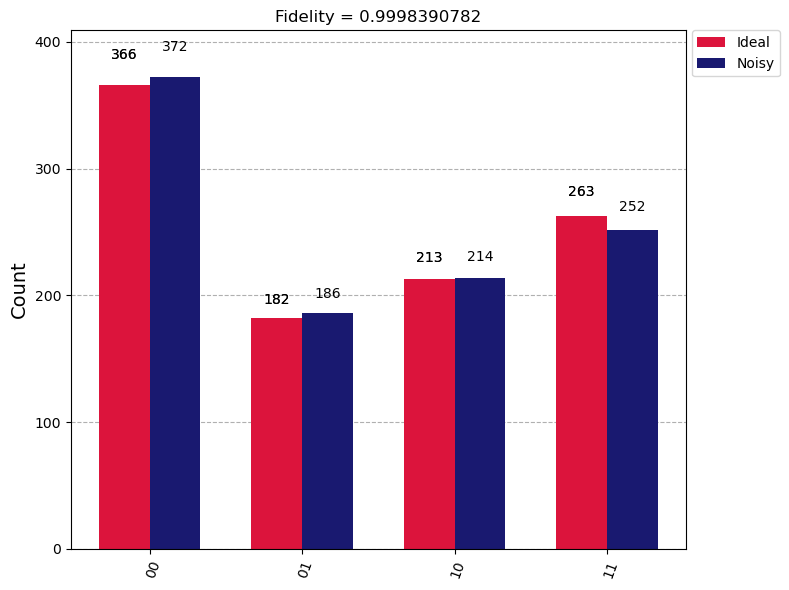

In [15]:
# run both circuits, calculate fidelity and plot histograms
fid, counts_exact, counts_decomp = circuit_fidelity(number_of_qubits, qc_exact, qc_noisy, total_noise_model)

legend = ['Ideal', 'Noisy']

plot_histogram([counts_exact, counts_decomp], figsize=(8,6), legend=legend, color=['crimson','midnightblue'],
                title=f'Fidelity = {fid:.10f}')

# Print the ideal circuit

In [ ]:
print(qc_exact)

     ┌───┐┌──────────┐┌─┐   
q_0: ┤ I ├┤0         ├┤M├───
     ├───┤│  U(0, 1) │└╥┘┌─┐
q_1: ┤ I ├┤1         ├─╫─┤M├
     └───┘└──────────┘ ║ └╥┘
c: 2/══════════════════╩══╩═
                       0  1 


# Print the Noisy/Decomposed Circuit

In [ ]:
print(qc_noisy)

     ┌───────┐ ┌────────────┐ ┌───────────┐ ┌─────────────┐┌───────────┐»
q_0: ┤ Rz(0) ├─┤ Rx(2.2004) ├─┤ Ry(1.546) ├─┤ Rx(-1.8234) ├┤1          ├»
     ├───────┤┌┴────────────┤┌┴───────────┴┐├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rz(0) ├┤ Rx(0.65309) ├┤ Ry(0.97697) ├┤ Rx(-2.0869) ├┤0          ├»
     └───────┘└─────────────┘└─────────────┘└─────────────┘└───────────┘»
c: 2/═══════════════════════════════════════════════════════════════════»
                                                                        »
«     ┌──────────┐┌────────────┐┌───────────┐┌───────────┐┌──────────────┐»
«q_0: ┤ Rx(-π/4) ├┤ Ry(1.5372) ├┤ Rx(-3π/4) ├┤1          ├┤ Rx(-0.83516) ├»
«     ├──────────┤├────────────┤├───────────┤│  Rxx(π/2) │└┬────────────┬┘»
«q_1: ┤ Rx(3π/4) ├┤ Ry(2.4084) ├┤ Rx(-3π/4) ├┤0          ├─┤ Rx(2.8688) ├─»
«     └──────────┘└────────────┘└───────────┘└───────────┘ └────────────┘ »
«c: 2/════════════════════════════════════════════════════════════════════»
«                         